## Quantile Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
az.style.use("arviz-darkgrid")
SEED = 12947


Usually when doing regression we model the conditional mean of some distribution. Common cases are a Normal distribution for continuous unbounded responses, a Poisson distribution for count data, etc.

Quantile regression, instead estimates a conditional quantile of the response variable. If the quantile is 0.5, then we will be estimating the median (instead of the mean), this could be useful as a way of performing robust regression, in a similar fashion as using a Student-t distribution instead of a Normal. But for some problem we actually care of the behaviour of the response away from the mean (or median). For example, in medical research, pathologies or potential health risks occur at high or low quantile, for instance, overweight and underweight. In some other fields like ecology, quantile regression is justified due to the existence of complex interactions between variables, where the effect of one variable on another is different for different ranges of the variable.

## Asymmetric Laplace distribution

At first it could be weird to think which distribution we should use as the likelihood for quantile regression or how to write a Bayesian model for quantile regression. But it turns out the answer is quite simple, we just need to use the asymmetric Laplace distribution. This distribution has one parameter controling the mean, another for the scale and a third one for the asymmetry. There is at least two alternative parametrizations regarding this asymmetric parameter. In terms of $\kappa$ a parameter that goes from 0 to $\infty$ and in terms of $q$ a number between 0 and 1. This later parametrization is more intuitive for quantile regression as we can directly interpre it as the quantile of interest.

On the next cell we compute the pdf of 3 distribution from the Asymmetric Laplace family

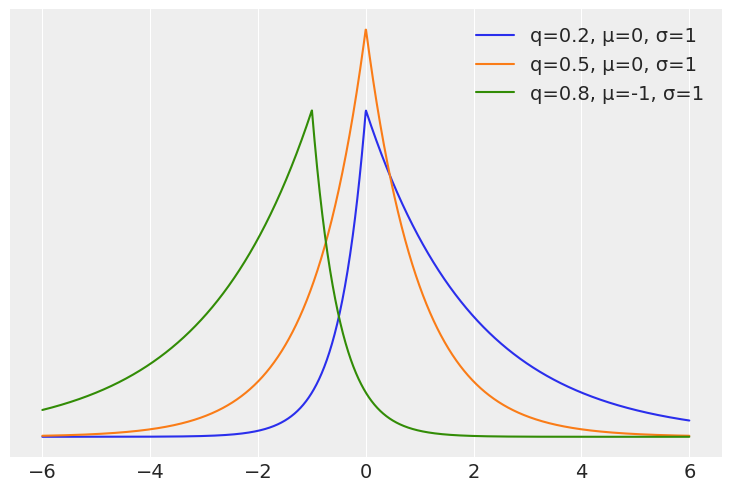

In [3]:
x = np.linspace(-6, 6, 2000)
quantiles =  np.array([0.2, 0.5, 0.8])
for q, m in zip(quantiles, [0, 0, -1]):
    κ = (q/(1-q))**0.5
    plt.plot(x, stats.laplace_asymmetric(κ, m, 1).pdf(x), label=f"q={q:}, μ={m}, σ=1")
plt.yticks([]);
plt.legend();

We are going to use a simple dataset to model the Body Mass Index for Dutch kids and young men as a function of their age.

In [4]:
data = pd.read_csv("data/bmi.csv")
data.head()

,age,bmi
0,0.03,13.235289
1,0.04,12.438775
2,0.04,14.541775
3,0.04,11.773954
4,0.04,15.325614


As we can see from the next figure the relationship between BMI and age is far from linear, and hence we are going to use splines.

Text(0, 0.5, 'BMI')

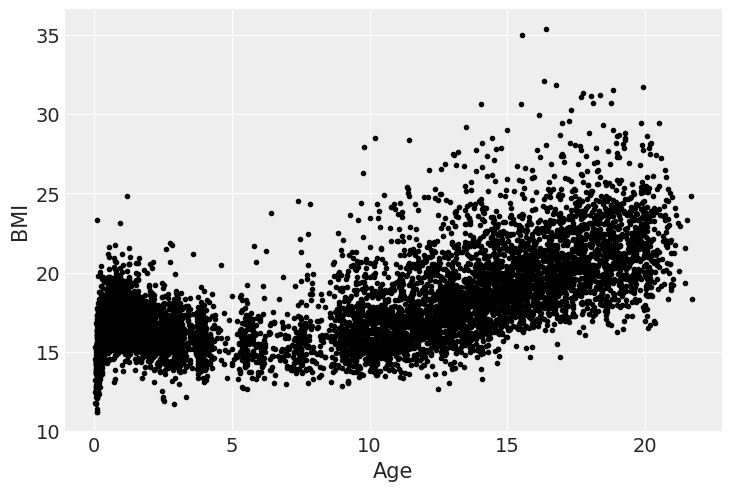

In [5]:
plt.plot(data.age, data.bmi, "k.");
plt.xlabel("Age")
plt.ylabel("BMI")

We are going to model 3 quantiles, 0.1, 0.5 and 0.9. For that reasoson we are going to fit 3 separated models, being the sole different the value of `kappa ` of the Asymmetric Laplace distribution, that will be fix at a different value each time. In the future Bambi will allow to directly work with the parameter `q` instead of `kappa`, in the meantime we have to apply a transformation to go from quantiles to suitable values of `kappa`.

$$
\kappa = \sqrt{\frac{q}{1 - q}}
$$

In [6]:
quantiles = np.array([0.1, 0.5, 0.9])
kappas = (quantiles/(1-quantiles))**0.5

knots = np.quantile(data.age, np.linspace(0, 1, 10))[1:-1]

idatas = []
for κ in kappas:
    model = bmb.Model("bmi ~ bs(age, knots=knots)",
                      data=data, family="asymmetriclaplace", priors={"kappa": κ})
    idata = model.fit()
    model.predict(idata)
    idatas.append(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(age, knots = knots), bmi_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(age, knots = knots), bmi_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(age, knots = knots), bmi_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


We can see the result of the 3 fitted curves in the next figure. One feature that stand-out is that the gap or distance between the median (orange) line and the two other lines is not the same. Also the shapes of the curve while following a similar pattern, are not exactly the same.

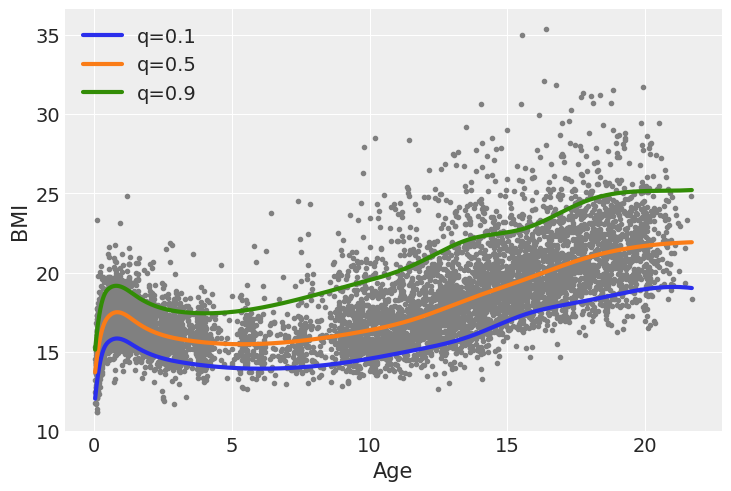

In [7]:
plt.plot(data.age, data.bmi, ".", color="0.5")
for idata, q in zip(idatas, quantiles):
    plt.plot(data.age.values, idata.posterior["bmi_mean"].mean(("chain", "draw")),
            label=f"q={q:}", lw=3);
    
plt.legend()
plt.xlabel("Age")
plt.ylabel("BMI");

 To better undestand these remarks let's compute a simple linear regression and then compute the same 3 quantiles from that fit. 

In [8]:
model_g = bmb.Model("bmi ~ bs(age, knots=knots)",
                  data=data)
idata_g = model_g.fit()
model_g.predict(idata_g, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(age, knots = knots), bmi_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


In [9]:
idata_g_mean_quantiles = idata_g.posterior_predictive["bmi"].quantile(quantiles, ("chain", "draw"))

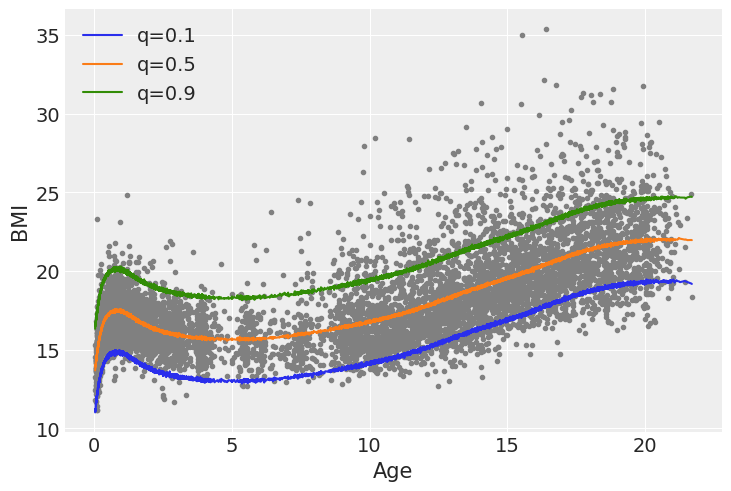

In [10]:
plt.plot(data.age, data.bmi, ".", color="0.5")
for q in quantiles:
    plt.plot(data.age.values, idata_g_mean_quantiles.sel(quantile=q),
            label=f"q={q:}");
    
plt.legend()
plt.xlabel("Age")
plt.ylabel("BMI");

We can see that when we use a Gaussian family and from that fit we compute the quantiles, the quantiles  q=0.1 and q=0.9 are symetrical with respect to q=0.5, also the shape of the curves is essentially the same just shifted up or down. Additionally the Asymmetric Laplace family allows the model to account for the increased variability in BMI as the age increases, while for the Gaussian family that variability always stays the same.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Dec 08 2022

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.6.0

arviz     : 0.15.0.dev0
numpy     : 1.23.4
pandas    : 1.5.1
bambi     : 0.9.1
scipy     : 1.9.3
matplotlib: 3.5.2

Watermark: 2.3.1

